# Code for Creating a Zarr Store from netcdf files

1. Create Zarr store template on a google bucket
2. Create a function to files by time slice
3. Create function to start the Gateway cluster
4. Run!

Because we are writing to a cloud bucket, we need to deal with authentication and that can cause a lot of headaches when sending tasks to Dask Workers. See the notes below on how to get the authentication to work.

## Get the file names for the netcdfs

In [1]:
import gcsfs
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)
# all .nc
base = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf"
all_nc = sorted(fs.glob(f"{base}/chla_z_*.nc"))
# keep only v1 (exclude anything with _v2 anywhere in the name)
paths_v1 = ["gcs://" + p for p in all_nc if "_v2" not in p]
paths_v2 = ["gcs://" + p for p in all_nc if "_v2" in p]
print("files:", len(paths_v1), "first:", paths_v1[0])
print("files:", len(paths_v2), "first:", paths_v2[0])

files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305.nc
files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc


## Make template

In [ ]:
%%script false
# THIS CODE WILL DELETE THE ZARR AT zarr_path
# DO NOT RUN ON A Zarr you do not want deleted

import numpy as np
import zarr
import gcsfs

# --- dimensions from your dataset ---
n_time = 560
n_z    = 20
n_lat  = 4320
n_lon  = 8640

chunks_4d = (1, 1, 480, 480)     # CHLA
chunks_3d = (1, 480, 480)        # (time, lat, lon) metrics
chunks_2d = (1, 1)               # (time, z) z_thickness (or (1, 20) if you prefer fewer chunks)
chunks_1d_time = (n_time,)
chunks_1d_z    = (n_z,)
chunks_1d_lat  = (n_lat,)
chunks_1d_lon  = (n_lon,)

fill_f4 = np.nan

# --- open a GCS-backed Zarr store ---
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

zarr_path = "gs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"  # change as needed
gcs_prefix = zarr_path.replace("gs://", "")  # gcsfs wants "bucket/path", not "gs://..."

# --- ensure the store is truly empty ---
# If it exists, delete everything under the prefix (recursive).
if fs.exists(gcs_prefix):
    fs.rm(gcs_prefix, recursive=True)

store = gcsfs.GCSMap(root=zarr_path, gcs=fs, check=False, create=True)

# --- create group (zarr v3) ---
root = zarr.group(store=store, overwrite=True, zarr_format=3)

def create_xarray_array(name, shape, chunks, dtype, fill_value, dims):
    """
    Create a Zarr v3 array with the dimension metadata xarray requires.
    """
    arr = root.create_array(
        name,
        shape=shape,
        chunks=chunks,
        dtype=dtype,
        fill_value=fill_value,
        overwrite=True,
        dimension_names=tuple(dims),   # <-- REQUIRED for xarray with zarr_format=3
    )
    # Optional compatibility/helpfulness (won't hurt)
    arr.attrs["_ARRAY_DIMENSIONS"] = list(dims)
    return arr

# ---- data vars ----
create_xarray_array(
    "CHLA",
    shape=(n_time, n_z, n_lat, n_lon),
    chunks=chunks_4d,
    dtype="f4",
    fill_value=fill_f4,
    dims=("time", "z", "lat", "lon"),
)

for v in ["CHLA_int_0_200", "CHLA_peak", "CHLA_peak_depth", "CHLA_depth_center_of_mass"]:
    create_xarray_array(
        v,
        shape=(n_time, n_lat, n_lon),
        chunks=chunks_3d,
        dtype="f4",
        fill_value=fill_f4,
        dims=("time", "lat", "lon"),
    )

create_xarray_array(
    "z_thickness",
    shape=(n_time, n_z),
    chunks=chunks_2d,
    dtype="f4",
    fill_value=fill_f4,
    dims=("time", "z"),
)

# ---- coords / 1D vars ----
create_xarray_array("time", shape=(n_time,), chunks=chunks_1d_time, dtype="datetime64[ns]", fill_value=None, dims=("time",))
create_xarray_array("z",    shape=(n_z,),    chunks=chunks_1d_z,    dtype="f4",            fill_value=None, dims=("z",))
create_xarray_array("lat",  shape=(n_lat,),  chunks=chunks_1d_lat,  dtype="f4",            fill_value=None, dims=("lat",))
create_xarray_array("lon",  shape=(n_lon,),  chunks=chunks_1d_lon,  dtype="f4",            fill_value=None, dims=("lon",))

# z_start / z_end are 1D along z (aux coords)
create_xarray_array("z_start", shape=(n_z,), chunks=chunks_1d_z, dtype="f4", fill_value=None, dims=("z",))
create_xarray_array("z_end",   shape=(n_z,), chunks=chunks_1d_z, dtype="f4", fill_value=None, dims=("z",))

# -----------------------------
# 6) Fill coord values (small writes, fast)
# -----------------------------
day_strs = [p.split("chla_z_")[1].split(".nc")[0] for p in paths_v1]
all_times = np.array(
    pd.to_datetime(sorted(set(day_strs)), format="%Y%m%d"),
    dtype="datetime64[ns]"
)

ds0 = xr.open_dataset(paths_v2[10], engine="h5netcdf", chunks={})
lat = ds0["lat"].values.astype("f4")
lon = ds0["lon"].values.astype("f4")
z   = ds0["z"].values.astype("f4")
z_start = ds0["z_start"].values.astype("f4")
z_end   = ds0["z_end"].values.astype("f4")

root["time"][:] = all_times
root["z"][:]    = z
root["lat"][:]  = lat
root["lon"][:]  = lon
root["z_start"][:] = z_start
root["z_end"][:]   = z_end

# (optional but nice) mark which arrays are coords for xarray
root.attrs["coordinates"] = "time z lat lon z_start z_end"

print("✅ Metadata-only Zarr v3 template created at:", zarr_path)


## Create a function to upload one slice of Zarr

There are a few key things that are special about the function that defines the dask tasks that are given to Dask Gateway workers.

* Gateway workers will not have access to the credential json file for GCS, so that needs to be passed in.
* It is important that GCP_SA_JSON is define before `open_zarr()` is defined so that the json text is part of the function.
* We want each file to be a separate worker but for each file, the dask graph for that (i.e. dealing with the chunks in the netcdf) should be done in threads in that worker. So it is essential that we set `dask.config.set(scheduler="threads")`. If we do not, dask will try to spread the dask graph for the single file tasks across all the workers and you will get a serialization error.

In [11]:
with open("/home/jovyan/.config/gcloud/application_default_credentials.json") as f:
    GCP_SA_JSON = f.read()

def one_zarr(
    path,
    gcp_sa_json=GCP_SA_JSON,
):
    import numpy as np
    import xarray as xr
    import fsspec
    import os
    import tempfile
    import uuid
    import dask

    cred_path = None
    try:
        # the path to the zarr bucket
        zarr_path = "gs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
        
        # --- Set up GCP AUTH VIA JSON file (inside worker) ---
        # cred_path is path to the gcs credential json
        # I added os.environ["GOOGLE_APPLICATION_CREDENTIALS"] due to problems with 401 (credentials) in workers
        if gcp_sa_json:
            cred_path = os.path.join(tempfile.gettempdir(), f"gcp_sa_worker_{uuid.uuid4().hex}.json")
            with open(cred_path, "w") as f:
                f.write(gcp_sa_json)
            os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = cred_path
        
        # --- open the day file (one day) ---
        # We can use storage_options={"token": "anon"} since this bucket is public
        # Try this if bucket is not public
        # storage_options={"token": cred_path} # token is defined above and points to the json cred file
        # but note that I was having credentialing issues in Gateway workers and had to set
        # os.environ["GOOGLE_APPLICATION_CREDENTIALS"], storage_options={"token": "google_default"}
        ds_day = xr.open_dataset(
            path, engine="h5netcdf", 
            chunks={}, 
            storage_options={"token": 'anon'})

        lat_chunk = 480
        lon_chunk = 480
        ds_day = ds_day.chunk({"time": 1, "z": 1, "lat": lat_chunk, "lon": lon_chunk})

        # --- find the time index in the store for this day ---
        ds_store = xr.open_zarr(zarr_path, 
                        consolidated=False, # zarr v3: use consolidated=False
                        storage_options={"token": "anon"})  

        t = np.asarray(ds_day["time"].values).astype("datetime64[ns]")[0]
        ti_arr = np.where(ds_store["time"].values == t)[0]
        if len(ti_arr) != 1:
            raise ValueError(f"Could not uniquely match time {t} in store (matches={len(ti_arr)})")
        ti = int(ti_arr[0])

        # --- already-uploaded check via z_thickness ---
        # If z_thickness has any non-NaN for this time, skip writing
        with dask.config.set(scheduler="threads"): # ensure that dask tasks are spread across threads not workers
            if "z_thickness" in ds_store:
                already = ds_store["z_thickness"].isel(time=ti).notnull().any().compute()
                if bool(already):
                    return f"SKIP (already uploaded): {path}"
            # If z_thickness missing, we don't skip (write proceeds)

        # drop vars wo time
        ds_write = ds_day.drop_vars(["lat", "lon", "z", "z_start", "z_end"], errors="ignore")

        # See comments above on why I used storage_options={"token": "google_default"}
        with dask.config.set(scheduler="threads"): # ensure that dask tasks are spread across threads not workers
            ds_write.to_zarr(
                zarr_path,
                storage_options={"token": "google_default"},
                mode="r+",
                region={"time": slice(ti, ti + 1)},
                consolidated=False,
            )
        return f"WROTE: {path}"

    finally:
        if cred_path and os.path.exists(cred_path):
            try:
                os.remove(cred_path)
            except Exception:
                pass


### Test the `one_zarr()` function

Note, if you have a credential json file in `/home/jovyan/.config/gcloud` then `open_zarr()` might work in your notebook but might not work in Gateway works that don't have that file. You might try temporarily renaming your `application_default_credentials.json`, when testing your Gateway worker function with that new file name like so. That way you can test authentication issues without having to start up a Gateway worker cluster.
```
with open("/home/jovyan/.config/gcloud/TEST_application_default_credentials.json") as f:
    GCP_SA_JSON = f.read()
```
and then trying `one_zarr()`. That should mimic what information the Gateway workers have.

In [12]:
%%time
# test one file. Takes 8 min or so per file
i = 263
one_zarr(paths_v2[i])

CPU times: user 1min 10s, sys: 14.8 s, total: 1min 25s
Wall time: 7min 20s


'WROTE: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20241206_v2.nc'

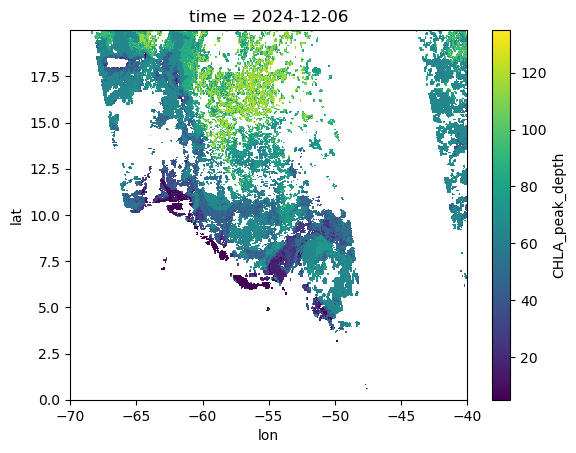

In [14]:
import xarray as xr
i = 263
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})
ds["CHLA_peak_depth"].isel(time=i).sel(lat=slice(20,0), lon=slice(-70,-40)).plot();

## Gateway pipeline

In [2]:
# --------------
# Get paths to netcdf files
# --------------
import gcsfs
# our bucket is public but if it were not use this
# token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
# fs = gcsfs.GCSFileSystem(token=token)
fs = gcsfs.GCSFileSystem(token="anon")
base = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf"
all_nc = sorted(fs.glob(f"{base}/chla_z_*.nc"))
paths_v2 = ["gcs://" + p for p in all_nc if "_v2" in p]
print("files:", len(paths_v2), "first:", paths_v2[0])

# --------------
# Set up cluster
# --------------
from dask_gateway import Gateway
# Dask-Gateway settings
MIN_WORKERS = 4
MAX_WORKERS = 20

def main():
    # 1. Dask-Gateway cluster setup
    gateway = Gateway()
    options = gateway.cluster_options()
    # open_zarr() doesn't require much resources so use defaule of 7.5Gi
#    setattr(options, "worker_resource_allocation", '4CPU, 30.2Gi')
    
    cluster = gateway.new_cluster(options)
    cluster.adapt(minimum=MIN_WORKERS, maximum=MAX_WORKERS)

    client = cluster.get_client()
    print(cluster)
    print(client)

    # Dashboard link (copy/paste into a browser tab)
    # e.g. if on a 2i2c hub it will look like xyz.2i2c.cloud/<dashboard link>
    print("Dask dashboard:", client.dashboard_link)

    # 2. Dispatch one task per granule
    # Make sure any tasks inside one_zarr that trigger dask graph (chunks) uses
    # with dask.config.set(scheduler="threads"):
    futures = client.map(one_zarr, paths_v2)
    # Map each future back to its (i, path) for printing failure/error info
    fut_info = {fut: (i, paths_v2[i]) for i, fut in enumerate(futures)}

    # 3. Print a summary of whether there were errors
    # as_completed means to print one_zarr() msg as files complete
    from dask.distributed import as_completed
 
    n = len(futures)
    done = 0
    errors = 0
    failed = []  # list of (i, path, error_repr)
    
    try:
        for fut in as_completed(futures):
            i, path = fut_info[fut]
            try:
                msg = fut.result()
                done += 1
                print(f"[{done}/{n}] (i={i}) {msg}")
            except Exception as e:
                errors += 1
                done += 1
                err = repr(e)
                failed.append((i, path, err))
                print(f"[{done}/{n}] (i={i}) ERROR: {err}\n    path={path}")
    finally:
        print(f"Finished. Success={done - errors}, Errors={errors}")
        if failed:
            print("\nFailed files:")
            for i, path, err in failed:
                print(f"  - i={i}  time/file={path}\n    {err}")
        client.close()
        cluster.close()
        

files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc


In [ ]:
# took 5 hours for 560 files
if __name__ == "__main__": main()

## Why Google credentials behave differently on Gateway workers

Locally this works
```
ds_write.to_zarr(
                ...,
                storage_options={"token": cred_path},
            )
```
where `cred_path` points to a local json file. Why doesn't that work on our Gateway workers?

Our `application_default_credentials.json` is **ADC user credentials** (`"type": "authorized_user"`), **not a service account key**. Open your file in `/home/jovyan/.config/gcloud` and look at the "type" field.

- **Locally** it works because your machine has a full gcloud/ADC context in the `/home/jovyan/.config/gcloud` directory, so OAuth refresh succeeds.
- **On Dask Gateway workers** (no `~/.config/gcloud`), passing `token="/path/to/json"` can fail because that path is often treated like a **service-account keyfile**, which an `authorized_user` JSON is not.
- Using `token="google_default"` tells gcsfs to use **ADC discovery (google-auth)**, which correctly loads `authorized_user` refresh tokens (when `GOOGLE_APPLICATION_CREDENTIALS` points to the json file).

**Rule of thumb**
- Public reads: `token="anon"`
- Distributed workers with user ADC: set `GOOGLE_APPLICATION_CREDENTIALS` and use `token="google_default"`
- Most robust for workers: use a **service account key** or workload identity